# Chapter 19 - Hyperparameter Optimization

## 19.1. What is Hyperparameter Optimization?

Deep neural networks come with a large number of parameters or weights that are learned during training. Additionally, every neural network has *hyperparameters* that need to be configured by the users. However, these hyperparameters cannot by adjusted by minimizing the training loss, because this would lead to overfitting on the training data.

*Hyperparameter optimization* (HPO) algorithms are designed to tackle this issue in a principled and automated fashion, by framing it as a global optimization problem. The default objective is the error on a hold-out validation dataset, but could in principle be any other business metric. It can be combined with or constrained by secondary objectives, such as training time, inference time, or model complexity.

Hyperparameter optimization also extends to *neural architecture search* (NAS), where the goal is to find entirely new neural network architectures. Both, HPO and NAS can be considered as sub-fields of AutoML, which aims to automate the entire ML pipeline.

### 19.1.1. The Optimization Problem

As an example, the toy problem here is to search for the leraning rate of the multi-class logistic regression model `SoftmaxRegression` to minimize the validation error on the Fashion-MNIST dataset.

In [1]:
import numpy as np
import torch
from scipy import stats
from torch import nn

from d2l import torch as d2l

#### 19.1.1.1. The Objective Function

The performance of a learning algorithm can be seen as a function $f: \mathcal{X} \rightarrow \mathbb{R}$ that maps from the hyperparameter space $\mathbf{x}\in\mathcal{X}$ to the validation loss. For every evaluation of $f(\mathbf{x})$, we have to train and validate the machine learning model, which can be time and compute intensive in the case of deep neural networks trained on large datasets. Given the criterion $f(\mathbf{x})$, the goal is to find $\mathbf{x}_{\star} \in \mathrm{argmin}_{\mathbf{x} \in \mathcal{X}} f(\mathbf{x})$.

The training of neural networks is stochastic (e.g., weights are randomly initialized, mini-batches are randomly sampled), so that our observations will be noisy: $y \sim f(\mathbf{x}) + \epsilon$, where we usually assume that $\epsilon \sim N(0, \sigma)$ the observation noise is Gaussian distributed.

We start with a method for computing the validation error of a model.

In [2]:
class HPOTrainer(d2l.Trainer):
    def validation_error(self):
        # set model to evaluation mode
        self.model.eval()

        accuracy = 0.
        val_batch_idx = 0

        for batch in self.val_dataloader:
            with torch.no_grad():
                x, y = self.prepare_batch(batch)
                y_hat = self.model(x)
                accuracy += self.model.accuracy(y_hat, y)

            val_batch_idx += 1

        val_err = 1 - accuracy / val_batch_idx

        return val_err

We use the `hpo_objective_softmax_classification` function to optimize validation error with respect to the hyperparameter configuration `config`, consisting of the `learning_rate`. For each evaluation, we train the model for `max_epochs` epochs, then compute and return its validation error:

In [3]:
def hpo_objective_softmax_classification(config, max_epochs=10):
    '''Objective function for hyperparameter optimization with softmax
    
    Parameters
    ----------
    config : dict
        Dictionary containing the hyperparameters to be optimized
    max_epochs : int
        Maximum number of epochs to train for
    
    Returns
    -------
    float
        Validation error of the trained model
    '''
    learning_rate = config['learning_rate']
    # create a trainer
    trainer = d2l.HPOTrainer(max_epochs=max_epochs)
    # load data
    data = d2l.FashionMNIST(batch_size=16)
    # create model
    model = d2l.SoftmaxRegression(num_outputs=10, lr=learning_rate)

    # train model
    trainer.fit(model=model, data=data)

    return trainer.validation_error().detach().numpy()

#### 19.1.1.2. The Configuration Space

Along with the objective function $f(\mathbf{x})$, we also need to define the feasible set $\mathbf{x}\in\mathcal{X}$ to optimize over, known as *configuration space* or *search space*.

In [4]:
config_space = {
    'learning_rate': stats.loguniform(1e-4, 1)
}

The `loguniform` function from `scipy` represents a uniform distribution between -4 to -1 in the log space.

Each hyperparameter has a data type, such as `float` for `learning_rate`, as well as a closed bounded range (i.e., lower and upper bounds). We usually assign a prior distribution (e.g., uniform or log-uniform) to each hyperparameter to sample from.

We will use the following table as our configuration space:

| Name | Type | Hyperparameter Ranges | log-scale |
| --- | --- | --- | --- |
| learning rate | float | $[10^{-6}, 10^{-1}]$ | yes |
| batch size | integer | $[8, 256]$ | yes |
| momentum | float | $[0.0, 0.99]$ | no |
| activation function | categorical | $\{\mathrm{tanh}, \mathrm{ReLU}\}$ |  |
| number of layers | integer | $[1, 6]$ | no |

The configuration space plays an important role for hyperparameter optimization, since no algorithms can find something that is not included in the configuration space. On the other hand, if the ranges are too large, the computation budget to find well performing configurations might become infeasible.

### 19.1.2. Random Search

The main idea of *random search* is to independently sample from the configuration space until a predefined budget (e.g., maximum number of iterations) is exhausted, and to return the best observed configuration. All evaluations can be executed independently in parallel.

    validation_error = 0.1711999773979187


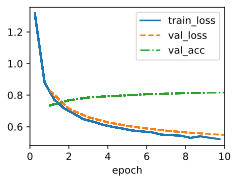

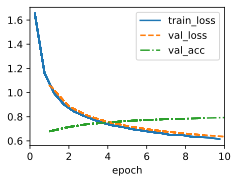

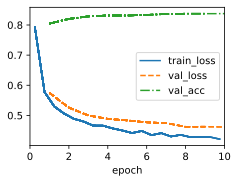

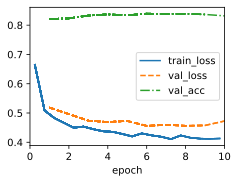

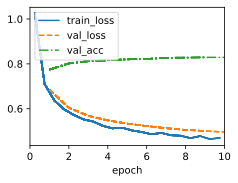

In [5]:
errors = []
values = []
num_iterations = 5

for i in range(num_iterations):
    # rvs() returns a random value from the loguniform distribution
    learning_rate = config_space['learning_rate'].rvs()
    print(f'Trial {i}: learning_rate = {learning_rate}')

    y = hpo_objective_softmax_classification({'learning_rate': learning_rate})
    print(f'    validation_error = {y}')
    values.append(learning_rate)
    errors.append(y)

The best learning rate is the one with the lowest validation error.

In [6]:
best_idx = np.argmin(errors) # index of the smallest error
best_lr = values[best_idx] # best learning rate
print(f'Optimal learning rate: {best_lr}')

Optimal learning rate: 0.012134049739080017


Due to its simplicity and generality, random search is one of the most frequently used HPO algorithms. It does not require any sophisticated implementation and can be applied to any configuration space as long as we can define some probability distribution for each hyperparameter.

## 19.2. Hyperparameter Optimization API

All HPO algoirthms need to implement two decision making primitives, *searching* and *scheduling*.
* Searching is to sample new hyperparameter configurations, which involves some search over the configuration space.
* Scheduling is to decide how many resources to allocate to each configuration.

Once we start to evaluate a configuration, we refer to it as a *trial*. We map these decisions to two classes: `HPOSearcher` and `HPOScheduler`. Besides that, we also provide a `HPOTuner` class that executes the optimization process.

This concept of scheduler and searcher is also implemented in Syne Tune, Ray Tune, or Optuna.

In [1]:
import time
from scipy import stats

from d2l import torch as d2l

### 19.2.1. Searcher

The `HPOSearcher` class is a base class for searcher, which provides a new candidate configuration through the `sample_configuration` funciton. The `update` function is used to update the history of previous trials, which can then be exploited to improve the sampling distribution.

In [3]:
class HPOSearcher(d2l.HyperParameters):
    def sample_configuration(self):
        raise NotImplementedError
    
    def update(self, config, error, additional_info):
        pass

The `RandomSearcher` class implements the random search optimizer. We also allow users to prescribe the first configuration to be evaluated via `initial_config`, while subsequent ones are drawn at random.

In [4]:
class RandomSearcher(HPOSearcher):
    def __init__(self, config_space, initial_config=None):
        self.save_hyperparameters()

    def sample_configuration(self):
        if self.initial_config is not None:
            result = self.initial_config
            self.initial_config = None
        else:
            result = {
                name: domain.rvs()
                for name, domain in self.config_space.items()
            }

        return result

### 19.2.2. Scheduler

Beyond sampling configurations for new trials, we also want to decide when and for how long to run a trial. This is done by the `HPOScheduler` class, which delegates the choice of new configurations to a `HPOSearcher` instance.

In the `HPOScheduler` class, the `suggest` method is used whenever some resource for training becomes available. Besides `sample_configuration` in the searcher, it may also decide upon parameters like `max_epochs`. In addition, the `update` method is called whenever a trial returns a new observation.

In [5]:
class HPOScheduler(d2l.HyperParameters):
    def sugguest(self):
        raise NotImplementedError
    
    def update(self, config, error, info=None):
        raise NotImplementedError

The `BasicScheduler` class implements a simple scheduler that simply schedules a new configuration every time new resources become available.

In [6]:
class BasicScheduler(HPOScheduler):
    def __init__(self, searcher):
        self.save_hyperparameters()

    def sugguest(self):
        return self.searcher.sample_configuration()
    
    def update(self, config, error, info=None):
        self.searcher.update(config, error, additional_info=info)

### 19.2.3. Tuner

Finally, we need a component that runs the scheduler and searcher in a loop, and does some book-keeping of the results. This is done by the `HPOTuner` class, which implements a sequential execution of the HPO trials that evaluates one training job after the next and will serve as a basic example.

In [7]:
class HPOTuner(d2l.HyperParameters):
    def __init__(self, scheduler, objective):
        self.save_hyperparameters()

        # bookkeeping results for plotting
        self.incumbent = None
        self.incumbent_error = None
        self.incumbent_trajectory = []
        self.cumulative_runtime = []
        self.current_runtime = 0
        self.records = []

    def run(self, number_of_trials):
        for i in range(number_of_trials):
            start_time = time.time()

            config = self.scheduler.sugguest()
            print(f'Trial {i}: config = {config}')

            error = self.objective(**config)
            error = float(error.cpu().detach().numpy())

            self.scheduler.update(config, error)
            runtime = time.time() - start_time

            self.bookkeeping(config, error, runtime)
            print(f'    error = {error}, runtime = {runtime}')

### 19.2.4. Bookkeeping the Performance of HPO Algorithms

For any HPO algorithm, the *incumbent* is the best configuration that we are interested so its validation error is the lowest after a given wall-clock time. This is why we track `runtime` per iteration in the `HPOTuner` class, which includes both the time to run an evaluation (call of `objective`) and the time to make a decision (call of `scheduler.suggest`).

We can use the `cumulative_runtime` and `incumbent_trajectory` to visualize the *any-time performance* of the HPO algorithm defined in terms of `scheduler` (and `searcher`). This helps us to quantify not only how well the configuration found by an optimizer works, but also how quickly an optimizer is able to find it.

In [8]:
# Complete version of the HPO tuner
class HPOTuner(d2l.HyperParameters):
    def __init__(self, scheduler, objective):
        self.save_hyperparameters()

        # bookkeeping results for plotting
        self.incumbent = None
        self.incumbent_error = None
        self.incumbent_trajectory = []
        self.cumulative_runtime = []
        self.current_runtime = 0
        self.records = []

    def run(self, number_of_trials):
        for i in range(number_of_trials):
            start_time = time.time()

            config = self.scheduler.sugguest()
            print(f'Trial {i}: config = {config}')

            error = self.objective(**config)
            error = float(error.cpu().detach().numpy())

            self.scheduler.update(config, error)
            runtime = time.time() - start_time

            self.bookkeeping(config, error, runtime)
            print(f'    error = {error}, runtime = {runtime}')

    # bookkeeping method for plotting
    def bookkeeping(self, config, error, runtime):
        self.records.append(
            {
                'config': config,
                'error': error,
                'runtime': runtime
            }
        )
        # check if the last hyperparameter configuration 
        # performs better than the incumbent
        if self.incumbent is None or self.incumbent_error > error:
            self.incumbent = config
            self.incumbent_error = error

        # add current best observed performance to the trajectory
        self.incumbent_trajectory.append(self.incumbent_error)
        # update runtime
        self.current_runtime += runtime
        self.cumulative_runtime.append(self.current_runtime)

### 19.2.5. Example: Optimizing the Hyperparameters of a CNN

We will use random search to optimize the *batch size* and *learning rate* of the `LeNet`. We start by defining the objective function, which will once more be validation error.

In [9]:
def hpo_objective_lenet(learning_rate, batch_size, max_epochs=10):
    '''Objective function for hyperparameter optimization with LeNet
    
    Parameters
    ----------
    learning_rate : float
        Learning rate of the optimizer
    batch_size : int
        Batch size for training
    max_epochs : int
        Maximum number of epochs to train for
        
    Returns
    -------
    float
        Validation error of the trained model
    '''
    # create a model
    model = d2l.LeNet(lr=learning_rate, num_classes=10)
    # create a trainer
    trainer = d2l.HPOTrainer(max_epochs=max_epochs, num_gpus=1)
    # load data
    data = d2l.FashionMNIST(batch_size=batch_size)

    # initialize model weights
    model.apply_init(
        [next(iter(data.get_dataloader(True)))[0]],
        d2l.init_cnn
    )
    # train model
    trainer.fit(model=model, data=data)
    # compute validation error
    validation_error = trainer.validation_error()

    return validation_error

Define the configuration space:

In [10]:
config_space = {
    'learning_rate': stats.loguniform(1e-2, 1),
    'batch_size': stats.randint(32, 256),
}

initial_config = {
    'learning_rate': 0.1,
    'batch_size': 128
}

    error = 0.2009238600730896, runtime = 124.4328453540802


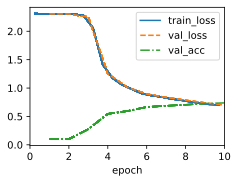

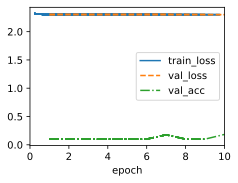

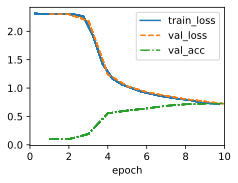

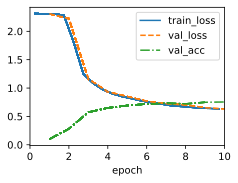

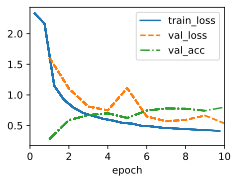

In [11]:
# create a searcher
searcher = RandomSearcher(config_space=config_space, 
                          initial_config=initial_config)
# create a scheduler
scheduler = BasicScheduler(searcher=searcher)
# create a tuner
tuner = HPOTuner(scheduler=scheduler,
                 objective=hpo_objective_lenet)

# run the tuner for 5 trials
tuner.run(number_of_trials=5)

We can plot the optimizaiton trajectory of the incumbent to get the any-time performance of random search:

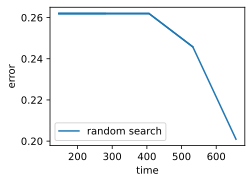

In [13]:
board = d2l.ProgressBoard(xlabel='time', ylabel='error')

for time_stamp, error in zip(tuner.cumulative_runtime, 
                             tuner.incumbent_trajectory):
    board.draw(time_stamp, error, 'random search', every_n=1)

### 19.2.6. Comparing HPO Algorithms

Each HPO run depends on two major sources of randomness:
* the random effects of the training process, such as random weight initialization or mini-batch ordering, and
* the intrinsic randomness of the HPO algorithm itself, such as the random sampling of random search.

Hence, when comparing different algorithms, it is crucial to run each experiment several times and report statistics, such as mean or median, across a population of multiple repetitions of an algorithm based on different seeds of the random number generator.

## 19.3. Asynchronous Random Search

In general, there are synchronous and asynchronous parallel hyperparameter optimizations.

In the synchronous case, we wait for all concurrently running trials to finish, before we start the next batch. 

In the asynchronous case, we immediately schedule a new trial as soon as resources become available.

The figure below illustrates the difference between synchronous and asynchronous parallel HPO.

![](../imgs/ch19/distributed_scheduling.svg)

We will look at asynchronous random search that, where trials are execuated in multiple python processes on the same machine. We will use *Syne Tune*, which provides a simple interface for asynchronous HPO.

In [1]:
import logging
from d2l import torch as d2l

logging.basicConfig(level=logging.INFO)
from syne_tune import StoppingCriterion, Tuner
from syne_tune.backend.python_backend.python_backend import PythonBackend
from syne_tune.config_space import loguniform, randint
from syne_tune.experiments import load_experiment
from syne_tune.optimizer.baselines import RandomSearch

sagemaker.config INFO - Not applying SDK defaults from location: C:\ProgramData\sagemaker\sagemaker\config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: C:\Users\User\AppData\Local\sagemaker\sagemaker\config.yaml


INFO:root:Ray Tune schedulers and searchers are not imported since dependencies are missing. You can install them with
   pip install 'syne-tune[raytune]'
or (for everything)
   pip install 'syne-tune[extra]'
INFO:root:SMAC is not imported (not contained in extra) since dependencies are missing. You can install them with
   pip install 'syne-tune[smac]'
or (for almost everything)
   pip install 'syne-tune[basic]'


### 19.3.1. Objective Function

The objective function should return the performance back to Syne Tune via the `report` callback.

In [2]:
def hpo_objective_lenet_synetune(learning_rate, batch_size, max_epochs):
    from syne_tune import Reporter
    # PythonBackend requires dependencies to be imported 
    # inside the function definition, so we import d2l again
    from d2l import torch as d2l

    # create a model
    model = d2l.LeNet(lr=learning_rate, num_classes=10)
    # create a trainer
    trainer = d2l.HPOTrainer(max_epochs=max_epochs, num_gpus=1)
    # load data
    data = d2l.FashionMNIST(batch_size=batch_size)

    # initialize model weights
    model.apply_init(
        [next(iter(data.get_dataloader(True)))[0]],
        d2l.init_cnn
    )

    # create a reporter
    report = Reporter()
    for epoch in range(1, max_epochs + 1):
        if epoch == 1:
            # initialize the state of the trainer
            trainer.fit(model=model, data=data)
        else:
            # continue training
            trainer.fit_epoch()

        # compute validation error
        validation_error = trainer.validation_error().cpu().detach().numpy()
        # report validation error
        report(epoch=epoch, validation_error=float(validation_error))

### 19.3.2. Asynchronous Scheduler

We need to define the number of workers that evaluate trials concurrently. Also need to specify how long we want to run random search, by defining an upper limit on the total wall-clock time.

In [3]:
num_workers = 2 # needs to be <= number of GPUs

max_wallclock_time = 12 * 60 # 12 miniutes

In [4]:
metric = 'validation_error' # metric to optimize
mode = 'min' # minimize metric

In [5]:
config_space = {
    "learning_rate": loguniform(1e-2, 1),
    "batch_size": randint(32, 256),
    "max_epochs": 10,
}
initial_config = {
    "learning_rate": 0.1,
    "batch_size": 128,
}

Next, we need to specify the backend for job executions. Here we just consider the distribution on a local machine where parallel jobs are executed as sub-processes. However, for large scale HPO, we could run this also on a cluster or cloud environment, where each trial consumes a full instance.

In [6]:
trial_backend = PythonBackend(
    tune_function=hpo_objective_lenet_synetune,
    config_space=config_space,
)

Create a scheduler for asynchronous random search:

In [7]:
scheduler = RandomSearch(
    config_space,
    metric=metric,
    mode=mode,
    points_to_evaluate=[initial_config],
)

INFO:syne_tune.optimizer.schedulers.scheduler_searcher:Master random_seed = 490321188
INFO:syne_tune.optimizer.schedulers.scheduler_searcher:max_resource_level = 10, as inferred from config_space


Create a `Tuner`, where the main experiment loop and bookkeeping is centralized, and interactions between scheduler and backend are mediated.

In [8]:
stop_criterion = StoppingCriterion(max_wallclock_time=max_wallclock_time)

# create a tuner
tuner = Tuner(
    trial_backend=trial_backend,
    scheduler=scheduler,
    stop_criterion=stop_criterion,
    n_workers=num_workers,
    print_update_interval=int(max_wallclock_time * 0.6)
)

In [9]:
tuner.run()

INFO:syne_tune.tuner:results of trials will be saved on C:\Users\User\syne-tune\python-entrypoint-2024-01-11-16-10-00-504
INFO:syne_tune.backend.local_backend:Detected 1 GPUs
INFO:syne_tune.backend.local_backend:running subprocess with command: c:\Users\User\anaconda3\envs\d2l\python.exe c:\Users\User\anaconda3\envs\d2l\lib\site-packages\syne_tune\backend\python_backend\python_entrypoint.py --learning_rate 0.1 --batch_size 128 --max_epochs 10 --tune_function_root C:\Users\User\syne-tune\python-entrypoint-2024-01-11-16-10-00-504\tune_function --tune_function_hash 3fb2304f089b50c509547461bd8ce86c --st_checkpoint_dir C:\Users\User\syne-tune\python-entrypoint-2024-01-11-16-10-00-504\0\checkpoints
INFO:syne_tune.tuner:(trial 0) - scheduled config {'learning_rate': 0.1, 'batch_size': 128, 'max_epochs': 10}
INFO:syne_tune.backend.local_backend:running subprocess with command: c:\Users\User\anaconda3\envs\d2l\python.exe c:\Users\User\anaconda3\envs\d2l\lib\site-packages\syne_tune\backend\pytho

--------------------
Resource summary (last result is reported):
 trial_id     status  iter  learning_rate  batch_size  max_epochs  epoch  validation_error  worker-time
        0  Completed    10       0.100000         128          10   10.0          0.222903   441.929563
        1  Completed    10       0.016538         164          10   10.0          0.900015   444.328650
        2 InProgress     0       0.012942         241          10      -                 -            -
        3 InProgress     0       0.021166          35          10      -                 -            -
2 trials running, 2 finished (2 until the end), 723.70s wallclock-time

validation_error: best 0.22290349006652832 for trial-id 0
--------------------


The logs of all evaluated hyperparameter configurations are stored for further analysis. At any time during the tuning job, we can easily get the results obtained so far and plot the incumbent trajectory.

c:\Users\User\anaconda3\envs\d2l\lib\site-packages\syne_tune\experiments\experiment_result.py:161: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


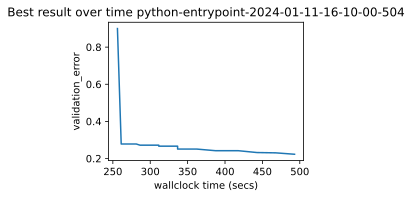

In [10]:
d2l.set_figsize()
tuning_experiment = load_experiment(tuner.name)
tuning_experiment.plot()

### 19.3.3. Visualize the Asynchronous Optimization Process

We can visualize how the learning curves of every trial evolve during the asynchronous optimization process.

Text(0, 0.5, 'objective function')

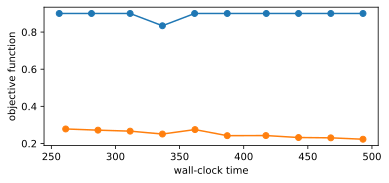

In [11]:
d2l.set_figsize([6, 2.5])
results = tuning_experiment.results

for trial_id in results.trial_id.unique():
    df = results[results["trial_id"] == trial_id]
    d2l.plt.plot(
        df["st_tuner_time"],
        df["validation_error"],
        marker="o"
    )

d2l.plt.xlabel("wall-clock time")
d2l.plt.ylabel("objective function")

## 19.4. Multi-Fidelity Hyperparameter Optimization

Multi-fidelity hyperparameter optimization (MFHPO) allocates more resources to promising configurations, and stop evaluations of poorly performing ones early.

In this case, our objective function $f(\mathbf{x})$ gets replaced by a *multi-fidelity* objective function $f(\mathbf{x}, r)$ that takes an additional input $r\in[r_{\min}, r_{\max}]$, specifying the amount of resources that we are willing to spend for the evaluation of configuration $\mathbf{x}$.

Assume that the error $f(\mathbf{x}, r)$ decreases with $r$, whereas the computational cost $c(\mathbf{x}, r)$ increases. Typically, $r$ represents the number of epochs for training the neural network, but it could also be the training subset size or the number of cross-validation folds.

In [12]:
from collections import defaultdict
import numpy as np
from scipy import stats

from d2l import torch as d2l
d2l.set_figsize()

### 19.4.1. Succesive Halving

The basic idea behind *successive halving* is to start with $N$ configurations, for example randomly sampled from the configuration space, and to train each of them for $r_{\min}$ epochs only. We then discard a fraction of the worst performing trials and train the remaining ones for longer. Iterating this process, fewer trials run for long, until at least one trial reaches the maximum budget $r_{\max}$.

Consider a minimum budget $r_{\min}$ (for example, 1 epoch), a maximum budget $r_{\max}$, for example `max_epochs`, and a halving constant $\eta\in{2, 3,\ldots}$. 

For simplicity, assume that $r_{\max} = r_{\min}\eta^K$, with $K \in \mathbb{I}$. The number of initial configurations is then $N=\eta^K$. We also define the set of rungs $\mathcal{R} = \{ r_{\mathrm{min}}, r_{\mathrm{min}}\eta, r_{\mathrm{min}}\eta^2, \dots, r_{max} \}$.

The successive halving algorithm is then defined as follows:
1. We start with running $N$ trials until the first rung $r_{\min}$.
2. Sorting the validation errors, we keep the top $1/\eta$ fraction (which amounts to $\eta^{K-1}$ configurations) and discard the rest.
3. The surviving trials are trained for the next rung $r_{\min}\eta$, and the process is repeated.
4. At each rung, a $1/\eta$ fraction of trials survives and their training continues with a $\eta$ times larget budget.
5. With this particular choice of $N$, only a single trial will be trained to the full budget $r_{\max}$.
6. Once such a round of successive halving is completed, we start the next one with a new set of initial configurations, iterating until the total budget is spent.

The `SuccessiveHalvingScheduler` class implements the successive halving algorithm. It is a subclass of `HPOScheduler`. It also takes the minimum resource budget `r_min`, the maximum resource budget `r_max`, and the halving constant `eta` as input arguments. Inside the scheduler, we maintain a queue of configurations that still needs to be evaluated for the current rung $r_i$. We update the queue every time we jump to the next rung.

In [13]:
class SuccessiveHalvingScheduler(d2l.HPOScheduler):
    def __init__(self, searcher, eta, r_min, r_max, perfact=1):
        self.save_hyperparameters()

        # compute K, which is later used to determine the number of configurations
        self.K = int(np.log(r_max / r_min) / np.log(eta))

        # define the rungs
        self.rung_levels = [r_min * eta ** k for k in range(self.K + 1)]
        if r_max not in self.rung_levels:
            # the final rung should be r_max
            self.rung_levels.append(r_max)
            self.K += 1

        # book-keeping
        self.observed_error_at_rungs = defaultdict(list)
        self.all_observed_error_at_rungs = defaultdict(list)

        # maintain a processing queue
        self.queue = []    

The `queue` is empty at first, and we fill it with `n = prefact * eta ** K` configurations, which are first evaluated on the smallest rung `r_min`. The `prefact` allows us to reuse our code in a different context. Here, we fix `prefact = 1`. Every time resources become available and the `HPOTuner` object queries the `suggest` function, we return an element from the queue. Once we finish one round of successive halving, which means that we evaluated all surviving configurations on the highest resource level `r_max` and our queue is empty, we start the entire process again with a new, randomly sampled set of configurations.

In [14]:
@d2l.add_to_class(SuccessiveHalvingScheduler)
def suggest(self):
    if len(self.queue) == 0:
        # start a new round of successive halving
        # Number of configurations for the first rung
        n0 = int(self.perfact * self.eta ** self.K)

        for _ in range(n0):
            config = self.searcher.sample_configuration()
            config['max_epochs'] = self.r_min # set r = r_min
            self.queue.append(config)

    # return an element from the queue
    return self.queue.pop()

When we collected a new data point, we first update the searcher module. Afterwards we check if we already collect all data points on the current rung. We sort all configurations and push the top $1/\eta$ configurations into the queue.

In [33]:
@d2l.add_to_class(SuccessiveHalvingScheduler)
def update(self, config, error, info=None):
    ri = int(config['max_epochs']) # Rung r_i

    # update the searcher, e.g., if we use Bayesian optimization
    self.searcher.update(config, error, additional_info=info)
    self.all_observed_error_at_rungs[ri].append((config, error))

    if ri < self.r_max:
        # book-keeping
        self.observed_error_at_rungs[ri].append((config, error))
        # determine how many configurations should be evaluated on this rung
        ki = self.K - self.rung_levels.index(ri)
        ni = int(self.perfact * self.eta ** ki)

        # If we observed all configurations on this rung r_i,
        # we estimate the top 1/eta configurations, add them to queue
        # and promote them for the next rung r_{i+1}
        if len(self.observed_error_at_rungs[ri]) >= ni:
            kiplus1 = ki - 1
            niplus1 = int(self.perfact * self.eta ** kiplus1)

            best_performing_configurations = self.get_top_n_configurations(
                rung_level=ri, n=niplus1
            )

            riplus1 = self.rung_levels[self.K - kiplus1] # rung r_{i+1}

            # queue may not be empty: insert new entries at the beginning
            self.queue = [
                dict(config, max_epochs=riplus1)
                for config in best_performing_configurations
            ] + self.queue
            # reset
            self.observed_error_at_rungs[ri] = []

Configurations are sorted based on their observed performance on the current rung.

In [16]:
@d2l.add_to_class(SuccessiveHalvingScheduler)
def get_top_n_configurations(self, rung_level, n):
    rung = self.observed_error_at_rungs[rung_level]

    if not rung:
        return []
    
    sorted_rung = sorted(rung, key=lambda x: x[1])

    return [x[0] for x in sorted_rung[:n]]

In [34]:
# Complete version of Successive Halving Scheduler
class SuccessiveHalvingScheduler(d2l.HPOScheduler):
    def __init__(self, searcher, eta, r_min, r_max, perfact=1):
        self.save_hyperparameters()

        # compute K, which is later used to determine the number of configurations
        self.K = int(np.log(r_max / r_min) / np.log(eta))

        # define the rungs
        self.rung_levels = [r_min * eta ** k for k in range(self.K + 1)]
        if r_max not in self.rung_levels:
            # the final rung should be r_max
            self.rung_levels.append(r_max)
            self.K += 1

        # book-keeping
        self.observed_error_at_rungs = defaultdict(list)
        self.all_observed_error_at_rungs = defaultdict(list)

        # maintain a processing queue
        self.queue = []   

    def suggest(self):
        if len(self.queue) == 0:
            # start a new round of successive halving
            # Number of configurations for the first rung
            n0 = int(self.perfact * self.eta ** self.K)

            for _ in range(n0):
                config = self.searcher.sample_configuration()
                config['max_epochs'] = self.r_min # set r = r_min
                self.queue.append(config)

        # return an element from the queue
        return self.queue.pop() 
    

    def update(self, config, error, info=None):
        ri = int(config['max_epochs']) # Rung r_i

        # update the searcher, e.g., if we use Bayesian optimization
        self.searcher.update(config, error, additional_info=info)
        self.all_observed_error_at_rungs[ri].append((config, error))

        if ri < self.r_max:
            # book-keeping
            self.observed_error_at_rungs[ri].append((config, error))
            # determine how many configurations should be evaluated on this rung
            ki = self.K - self.rung_levels.index(ri)
            ni = int(self.perfact * self.eta ** ki)

            # If we observed all configurations on this rung r_i,
            # we estimate the top 1/eta configurations, add them to queue
            # and promote them for the next rung r_{i+1}
            if len(self.observed_error_at_rungs[ri]) >= ni:
                kiplus1 = ki - 1
                niplus1 = int(self.perfact * self.eta ** kiplus1)

                best_performing_configurations = self.get_top_n_configurations(
                    rung_level=ri, n=niplus1
                )

                riplus1 = self.rung_levels[self.K - kiplus1] # rung r_{i+1}

                # queue may not be empty: insert new entries at the beginning
                self.queue = [
                    dict(config, max_epochs=riplus1)
                    for config in best_performing_configurations
                ] + self.queue
                # reset
                self.observed_error_at_rungs[ri] = []

    def get_top_n_configurations(self, rung_level, n):
        rung = self.observed_error_at_rungs[rung_level]

        if not rung:
            return []
        
        sorted_rung = sorted(rung, key=lambda x: x[1])

        return [x[0] for x in sorted_rung[:n]]

Check how successive halving works on a simple example:

In [35]:
# min number of epochs
r_min = 2
# max number of epochs
r_max = 10
# reduction factor
eta = 2
num_gpus = 1

config_space = {
    "learning_rate": stats.loguniform(1e-2, 1),
    "batch_size": stats.randint(32, 256),
}
initial_config = {
    "learning_rate": 0.1,
    "batch_size": 128,
}

In [36]:
# create a searcher
searcher = d2l.RandomSearcher(config_space=config_space,
                              initial_config=initial_config)

# create a scheduler
scheduler = SuccessiveHalvingScheduler(
    searcher=searcher,
    eta=eta,
    r_min=r_min,
    r_max=r_max,
)

# create a tuner
tuner = d2l.HPOTuner(scheduler=scheduler,
                     objective=d2l.hpo_objective_lenet)

    error = 0.17491143941879272, runtime = 130.4089024066925


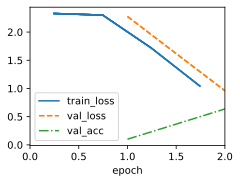

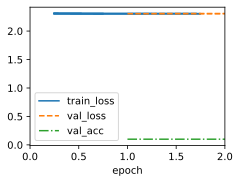

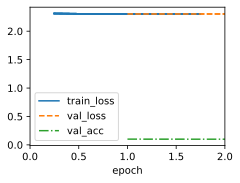

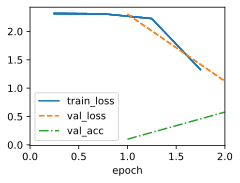

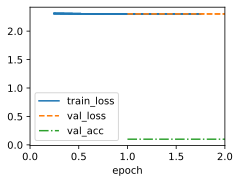

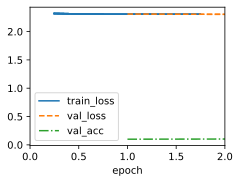

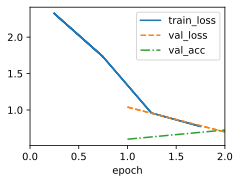

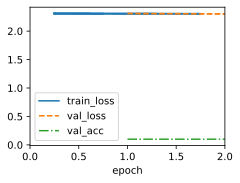

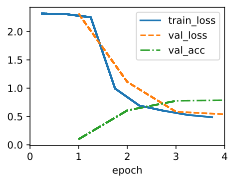

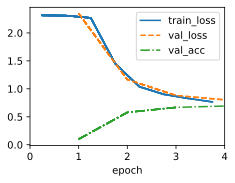

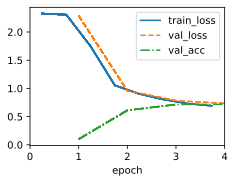

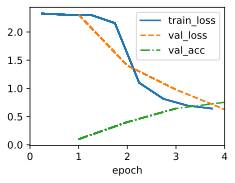

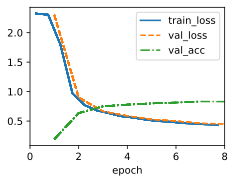

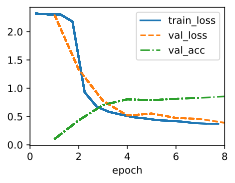

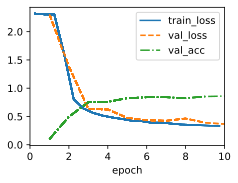

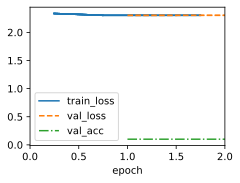

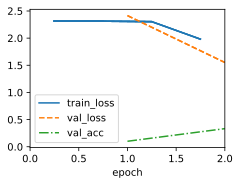

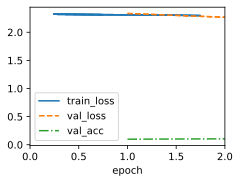

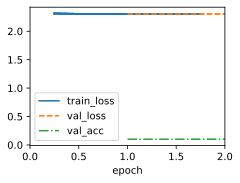

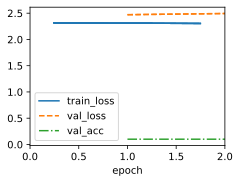

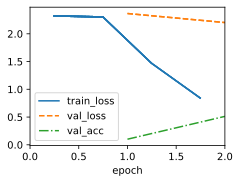

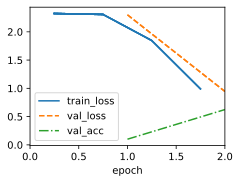

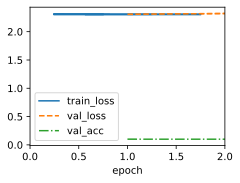

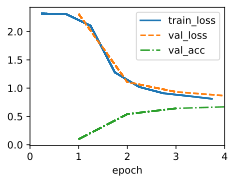

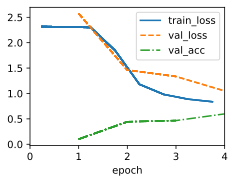

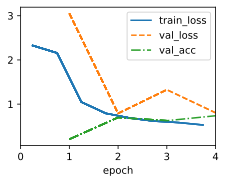

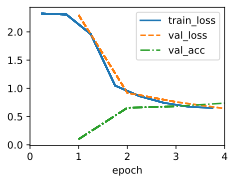

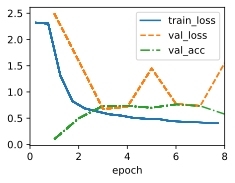

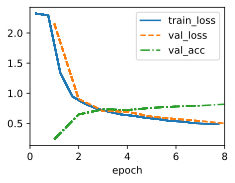

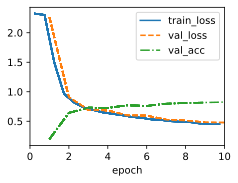

In [37]:
tuner.run(number_of_trials=30)

Text(0.5, 0, 'epochs')

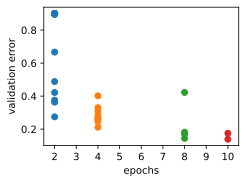

In [38]:
for rung_index, rung in scheduler.all_observed_error_at_rungs.items():
    errors = [xi[1] for xi in rung]
    d2l.plt.scatter([rung_index] * len(errors), errors)
d2l.plt.xlim(r_min - 0.5, r_max + 0.5)
d2l.plt.xticks(
    np.arange(r_min, r_max + 1),
    np.arange(r_min, r_max + 1)
)
d2l.plt.ylabel("validation error")
d2l.plt.xlabel("epochs")

## 19.5. Asynchronous Successive Halving

To run successive halving (SH) asynchronously in a distributed setting, before we can decide which configuration to run next, we first have to collect all observations at the current rung level. This requires to synchronize workers at each rung level. For the lowest rung level $r_{\min}$, we first have to evaluate all $N=\eta^K$ configurations, before we cam promote the top $1/\eta$ configurations to the next rung level.

![](../imgs/ch19/sync_sh.svg)

The figure above shows the scheduling of synchronous SH with $\eta=2$ for four different trials with two workers. We can see that Worker-1 is idle for a long time, while Worker-2 is busy, due to the synchronization barrier at the end of each rung level.

![](../imgs/ch19/asha.svg)

The asynchronous successive halving (ASHA) algorithm adapts SH to the aynchronous parallel scenario. The main idea of ASHA is to promote configurations to the next rung level as soon as we collected at least $\eta$ observations on the current rung level. This decision rule may lead to suboptimal promotions: configurations can be promoted to the next rung level, which in hindsight do not compare favourably against most others at the same rung level. In practice, such suboptimal initial promotions have only a modest impact on performance, not only because the ranking of hyperparameter configurations is often fairly consistent across rung levels, but also because rungs grow over time and reflect the distribution of metric values at this level better and better. The figure above shows the scheduling of the same configurations for ASHA. 

In [39]:
import logging
from d2l import torch as d2l

logging.basicConfig(level=logging.INFO)
from syne_tune import StoppingCriterion, Tuner
from syne_tune.backend.python_backend.python_backend import PythonBackend
from syne_tune.config_space import loguniform, randint
from syne_tune.experiments import load_experiment
from syne_tune.optimizer.baselines import ASHA

### 19.5.1. Objective Function

In [40]:
# same as Section 19.3
def hpo_objective_lenet_synetune(learning_rate, batch_size, max_epochs):
    from syne_tune import Reporter
    # PythonBackend requires dependencies to be imported 
    # inside the function definition, so we import d2l again
    from d2l import torch as d2l

    # create a model
    model = d2l.LeNet(lr=learning_rate, num_classes=10)
    # create a trainer
    trainer = d2l.HPOTrainer(max_epochs=max_epochs, num_gpus=1)
    # load data
    data = d2l.FashionMNIST(batch_size=batch_size)

    # initialize model weights
    model.apply_init(
        [next(iter(data.get_dataloader(True)))[0]],
        d2l.init_cnn
    )

    # create a reporter
    report = Reporter()
    for epoch in range(1, max_epochs + 1):
        if epoch == 1:
            # initialize the state of the trainer
            trainer.fit(model=model, data=data)
        else:
            # continue training
            trainer.fit_epoch()

        # compute validation error
        validation_error = trainer.validation_error().cpu().detach().numpy()
        # report validation error
        report(epoch=epoch, validation_error=float(validation_error))

In [42]:
# same configuration space as Section 19.3
min_num_of_epochs = 2
max_num_of_epochs = 10
eta = 2

config_space = {
    "learning_rate": loguniform(1e-2, 1),
    "batch_size": randint(32, 256),
    "max_epochs": max_num_of_epochs,
}
initial_config = {
    "learning_rate": 0.1,
    "batch_size": 128,
}

### 19.5.2. Asynchronous Scheduler

In [43]:
n_workers = 2  # Needs to be <= the number of available GPUs
max_wallclock_time = 12 * 60  # 12 minutes

In [44]:
metric = 'validation_error' # metric to optimize
mode = 'min' # minimize metric

resource_attr = 'epoch'

In [46]:
# create a scheduler
scheduler = ASHA(
    config_space=config_space,
    metric=metric,
    mode=mode,
    points_to_evaluate=[initial_config],
    max_resource_attr='max_epochs',
    resource_attr=resource_attr,
    grace_period=min_num_of_epochs,
    reduction_factor=eta,
)

INFO:syne_tune.optimizer.schedulers.scheduler_searcher:Master random_seed = 429581787
INFO:syne_tune.optimizer.schedulers.scheduler_searcher:max_resource_level = 10, as inferred from config_space


* `metric` and `resource_attr` specify the key names with the `report` callback,
* `max_resource_attr` dentoes which input to the objective function corresponds to `r_max`,
* `grace_period` provides `r_min`, and
* `reduction_factor` is the halving constant $\eta$.

In [47]:
trial_backend = PythonBackend(
    tune_function=hpo_objective_lenet_synetune,
    config_space=config_space,
)

stop_criterion = StoppingCriterion(max_wallclock_time=max_wallclock_time)
# create a tuner
tuner = Tuner(
    trial_backend=trial_backend,
    scheduler=scheduler,
    stop_criterion=stop_criterion,
    n_workers=n_workers,
    print_update_interval=int(max_wallclock_time * 0.6),
)
tuner.run()

INFO:syne_tune.tuner:results of trials will be saved on C:\Users\User\syne-tune\python-entrypoint-2024-01-11-19-12-09-734
INFO:syne_tune.backend.local_backend:Detected 1 GPUs
INFO:syne_tune.backend.local_backend:running subprocess with command: c:\Users\User\anaconda3\envs\d2l\python.exe c:\Users\User\anaconda3\envs\d2l\lib\site-packages\syne_tune\backend\python_backend\python_entrypoint.py --learning_rate 0.1 --batch_size 128 --max_epochs 10 --tune_function_root C:\Users\User\syne-tune\python-entrypoint-2024-01-11-19-12-09-734\tune_function --tune_function_hash 93e13ba6721abd007e05e3a8f5c0853f --st_checkpoint_dir C:\Users\User\syne-tune\python-entrypoint-2024-01-11-19-12-09-734\0\checkpoints
INFO:syne_tune.tuner:(trial 0) - scheduled config {'learning_rate': 0.1, 'batch_size': 128, 'max_epochs': 10}
INFO:syne_tune.backend.local_backend:running subprocess with command: c:\Users\User\anaconda3\envs\d2l\python.exe c:\Users\User\anaconda3\envs\d2l\lib\site-packages\syne_tune\backend\pytho

--------------------
Resource summary (last result is reported):
 trial_id     status  iter  learning_rate  batch_size  max_epochs  epoch  validation_error  worker-time
        0  Completed    10       0.100000         128          10   10.0          0.217662   436.448180
        1  Completed    10       0.163054         252          10   10.0          0.335177   436.068769
        2 InProgress     0       0.449228         135          10      -                 -            -
        3 InProgress     0       0.047724         186          10      -                 -            -
2 trials running, 2 finished (2 until the end), 724.04s wallclock-time

validation_error: best 0.21766215562820435 for trial-id 0
--------------------


c:\Users\User\anaconda3\envs\d2l\lib\site-packages\syne_tune\experiments\experiment_result.py:161: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


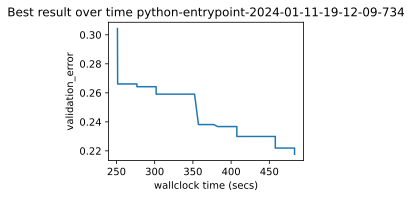

In [48]:
d2l.set_figsize()
e = load_experiment(tuner.name)
e.plot()

### 19.5.3. VIsualize the Optimization Process

Text(0, 0.5, 'objective function')

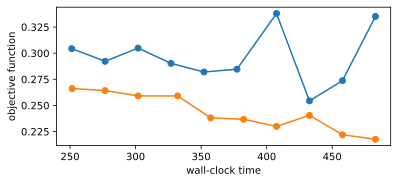

In [49]:
d2l.set_figsize([6, 2.5])
results = e.results
for trial_id in results.trial_id.unique():
    df = results[results["trial_id"] == trial_id]
    d2l.plt.plot(
        df["st_tuner_time"],
        df["validation_error"],
        marker="o"
    )
d2l.plt.xlabel("wall-clock time")
d2l.plt.ylabel("objective function")

Compared to random search, successive halving is not quite as trivial to run in an asynchronous distributed setting. To avoid synchronisation points, we promote configurations as quickly as possible to the next rung level, even if this means promoting some wrong ones. In practice, this usually does not hurt much, and the gains of asynchronous versus synchronous scheduling are usually much higher than the loss of the suboptimal decision making.